In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import warnings
warnings.filterwarnings(action = 'ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

In [3]:
# 경로 설정
import os
os.chdir('/content/drive/My Drive')

In [4]:
# 파일 불러오기
train = pd.read_csv('open/train.csv', encoding = 'utf-8')
test = pd.read_csv('open/test_x.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('open/sample_submission.csv', encoding = 'utf-8')

In [5]:
# train 데이터 살펴보기
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [6]:
# test 데이터 살펴보기
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


In [7]:
# sample_submission
sample_submission

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
19612,19612,0,0,0,0,0
19613,19613,0,0,0,0,0
19614,19614,0,0,0,0,0
19615,19615,0,0,0,0,0


# **전처리**

In [8]:
# 부호를 제거해주는 함수
def alpha_num(text) :
  return re.sub(r'[^A-Za-z0-9 ]', ' ', text)

train['text'] = train['text'].apply(alpha_num)

In [9]:
# 부호가 사라진 것을 확인할 수 있습니다.
train

,index,text,author
0,0,He was almost choking There was so much so m...,3
1,1,Your sister asked for it I suppose,2
2,2,She was engaged one day as she walked in per...,1
3,3,The captain was in the porch keeping himself ...,4
4,4,Have mercy gentlemen odin flung up his han...,3
...,...,...,...
54874,54874,Is that you Mr Smith odin whispered I h...,2
54875,54875,I told my plan to the captain and between us ...,4
54876,54876,Your sincere well wisher friend and sister...,1
54877,54877,Then you wanted me to lend you money,3


In [10]:
# 이상치 제거
train = train[train.text != "     "]
train = train.reset_index(drop=True)
train

,index,text,author
0,0,He was almost choking There was so much so m...,3
1,1,Your sister asked for it I suppose,2
2,2,She was engaged one day as she walked in per...,1
3,3,The captain was in the porch keeping himself ...,4
4,4,Have mercy gentlemen odin flung up his han...,3
...,...,...,...
54874,54874,Is that you Mr Smith odin whispered I h...,2
54875,54875,I told my plan to the captain and between us ...,4
54876,54876,Your sincere well wisher friend and sister...,1
54877,54877,Then you wanted me to lend you money,3


In [11]:
# nltk 불용어 및 불용어 추가
import nltk
nltk.download('stopwords')
stopwords=nltk.corpus.stopwords.words('english')
stopwords.append('odin')
stopwords.extend(['could', 'ought', 'would'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
# stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
#              "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
#              "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
#              "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
#              "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
#              "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
#              "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
#              "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
#              "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
#              "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
#              "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [13]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

In [14]:
train

,index,text,author
0,0,almost choking much much wanted say strange ex...,3
1,1,sister asked suppose,2
2,2,engaged one day walked perusing jane last lett...,1
3,3,captain porch keeping carefully way treacherou...,4
4,4,mercy gentlemen flung hands write anyway shame...,3
...,...,...,...
54874,54874,mr smith whispered hardly dared hope come,2
54875,54875,told plan captain us settled details accomplis...,4
54876,54876,sincere well wisher friend sister lucy,1
54877,54877,wanted lend money,3


In [15]:
# train test 분리
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])

In [16]:
X_train

array(['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked evident perplexity',
       'sister asked suppose',
       'engaged one day walked perusing jane last letter dwelling passages proved jane written spirits instead surprised mr saw looking meeting putting away letter immediately forcing smile said',
       ..., 'sincere well wisher friend sister lucy', 'wanted lend money',
       'certainly occurred said yes like'], dtype='<U1325')

# **모델링**

In [17]:
# 파라미터 설정
max_length = 500
padding_type = 'post'

In [18]:
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import Word2Vec

In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
# tokenize
train_token = [word_tokenize(sentence) for sentence in train['text']]
test_token = [word_tokenize(sentence) for sentence in test['text']]
all_token = train_token + test_token

In [21]:
# Word2Vec 생성
model_all = Word2Vec(sentences = all_token, size = 30, window = 3, min_count = 1, sg = 1, workers = 4, iter = 20)

In [22]:
# word token을 embedding vector로 변환
for i in range(len(all_token)) :
  for j in range(len(all_token[i])) :
    all_token[i][j] = model_all.wv.get_vector(all_token[i][j])

In [23]:
# padding
train_sequences = all_token[:len(train_token)]
train_padded = pad_sequences(train_sequences, padding = padding_type, maxlen = max_length)
test_sequences = all_token[len(train_token):]
test_padded = pad_sequences(test_sequences, padding = padding_type, maxlen = max_length)

In [24]:
train_padded.shape

(54879, 500, 30)

In [38]:
# 가벼운 NLP모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (500, 30)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(48, activation = 'relu'),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

In [39]:
# compile model
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

# model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling1d_1 ( (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 48)                1488      
_________________________________________________________________
dense_5 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 125       
Total params: 2,789
Trainable params: 2,789
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
# fit model
num_epochs = 30
history = model.fit(train_padded, y_train,
                    epochs = num_epochs, verbose = 2,
                    validation_split = 0.2)

Epoch 1/30
1372/1372 - 5s - loss: 1.5467 - accuracy: 0.2872 - val_loss: 1.4986 - val_accuracy: 0.3584
Epoch 2/30
1372/1372 - 4s - loss: 1.4362 - accuracy: 0.3792 - val_loss: 1.3903 - val_accuracy: 0.4074
Epoch 3/30
1372/1372 - 4s - loss: 1.3728 - accuracy: 0.4118 - val_loss: 1.3623 - val_accuracy: 0.4167
Epoch 4/30
1372/1372 - 4s - loss: 1.3543 - accuracy: 0.4195 - val_loss: 1.3480 - val_accuracy: 0.4220
Epoch 5/30
1372/1372 - 5s - loss: 1.3423 - accuracy: 0.4275 - val_loss: 1.3347 - val_accuracy: 0.4380
Epoch 6/30
1372/1372 - 4s - loss: 1.3329 - accuracy: 0.4350 - val_loss: 1.3254 - val_accuracy: 0.4381
Epoch 7/30
1372/1372 - 4s - loss: 1.3260 - accuracy: 0.4383 - val_loss: 1.3263 - val_accuracy: 0.4342
Epoch 8/30
1372/1372 - 4s - loss: 1.3211 - accuracy: 0.4428 - val_loss: 1.3151 - val_accuracy: 0.4429
Epoch 9/30
1372/1372 - 4s - loss: 1.3156 - accuracy: 0.4454 - val_loss: 1.3125 - val_accuracy: 0.4448
Epoch 10/30
1372/1372 - 4s - loss: 1.3102 - accuracy: 0.4518 - val_loss: 1.3154 - 

In [28]:
# predict values
pred = model.predict_proba(test_padded)

Instructions for updating:
Please use `model.predict()` instead.


In [29]:
# submission
sample_submission[['0', '1', '2', '3', '4']] = pred
sample_submission

,index,0,1,2,3,4
0,0,0.155868,0.382895,0.120408,0.242526,0.098303
1,1,0.153569,0.174280,0.159382,0.382467,0.130302
2,2,0.592801,0.057015,0.101166,0.153760,0.095258
3,3,0.026433,0.006501,0.828907,0.004411,0.133748
4,4,0.392599,0.305598,0.086171,0.096974,0.118658
...,...,...,...,...,...,...
19612,19612,0.037885,0.953127,0.004540,0.001171,0.003278
19613,19613,0.312469,0.024180,0.200374,0.216725,0.246252
19614,19614,0.125329,0.812120,0.021267,0.027556,0.013729
19615,19615,0.151502,0.765257,0.025547,0.038412,0.019282


In [ ]:
sample_submission.to_csv('submission_w2v_30.csv', index = False, encoding = 'utf-8')

# **split을 통해 얻은 test set으로 model 테스트 해보기**

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
# 자체 테스트를 위한 data split
xtrain, xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size = 0.3, random_state = 2020)

In [32]:
xtrain_token = [word_tokenize(sentence) for sentence in xtrain]
xtest_token = [word_tokenize(sentence) for sentence in xtest]

In [33]:
for i in range(len(xtrain_token)) :
  for j in range(len(xtrain_token[i])) :
    xtrain_token[i][j] = model_all.wv.get_vector(xtrain_token[i][j])

for i in range(len(xtest_token)) :
  for j in range(len(xtest_token[i])) :
    xtest_token[i][j] = model_all.wv.get_vector(xtest_token[i][j])

In [34]:
xtrain_sequences = xtrain_token
xtrain_padded = pad_sequences(xtrain_sequences, padding = padding_type, maxlen = max_length)
xtest_sequences = xtest_token
xtest_padded = pad_sequences(xtest_sequences, padding = padding_type, maxlen = max_length)

In [41]:
pred_test = model.predict_proba(xtest_padded)

In [42]:
# Logloss 함수
def multiclass_logloss(actual, predicted, eps=1e-15):

    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [43]:
multiclass_logloss(ytest, pred_test, eps=1e-15)

1.281868226243587

# **Word2Vec 시각화**

In [44]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [45]:
word_vectors = model_all.wv

In [46]:
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

In [47]:
pca = PCA(n_components = 2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:, 0]
ys = xys[:, 1]

In [48]:
def plot_2d_graph(vocabs, xs, ys) :
  plt.figure(figsize = (30, 20))
  plt.scatter(xs, ys, marker = 'o')

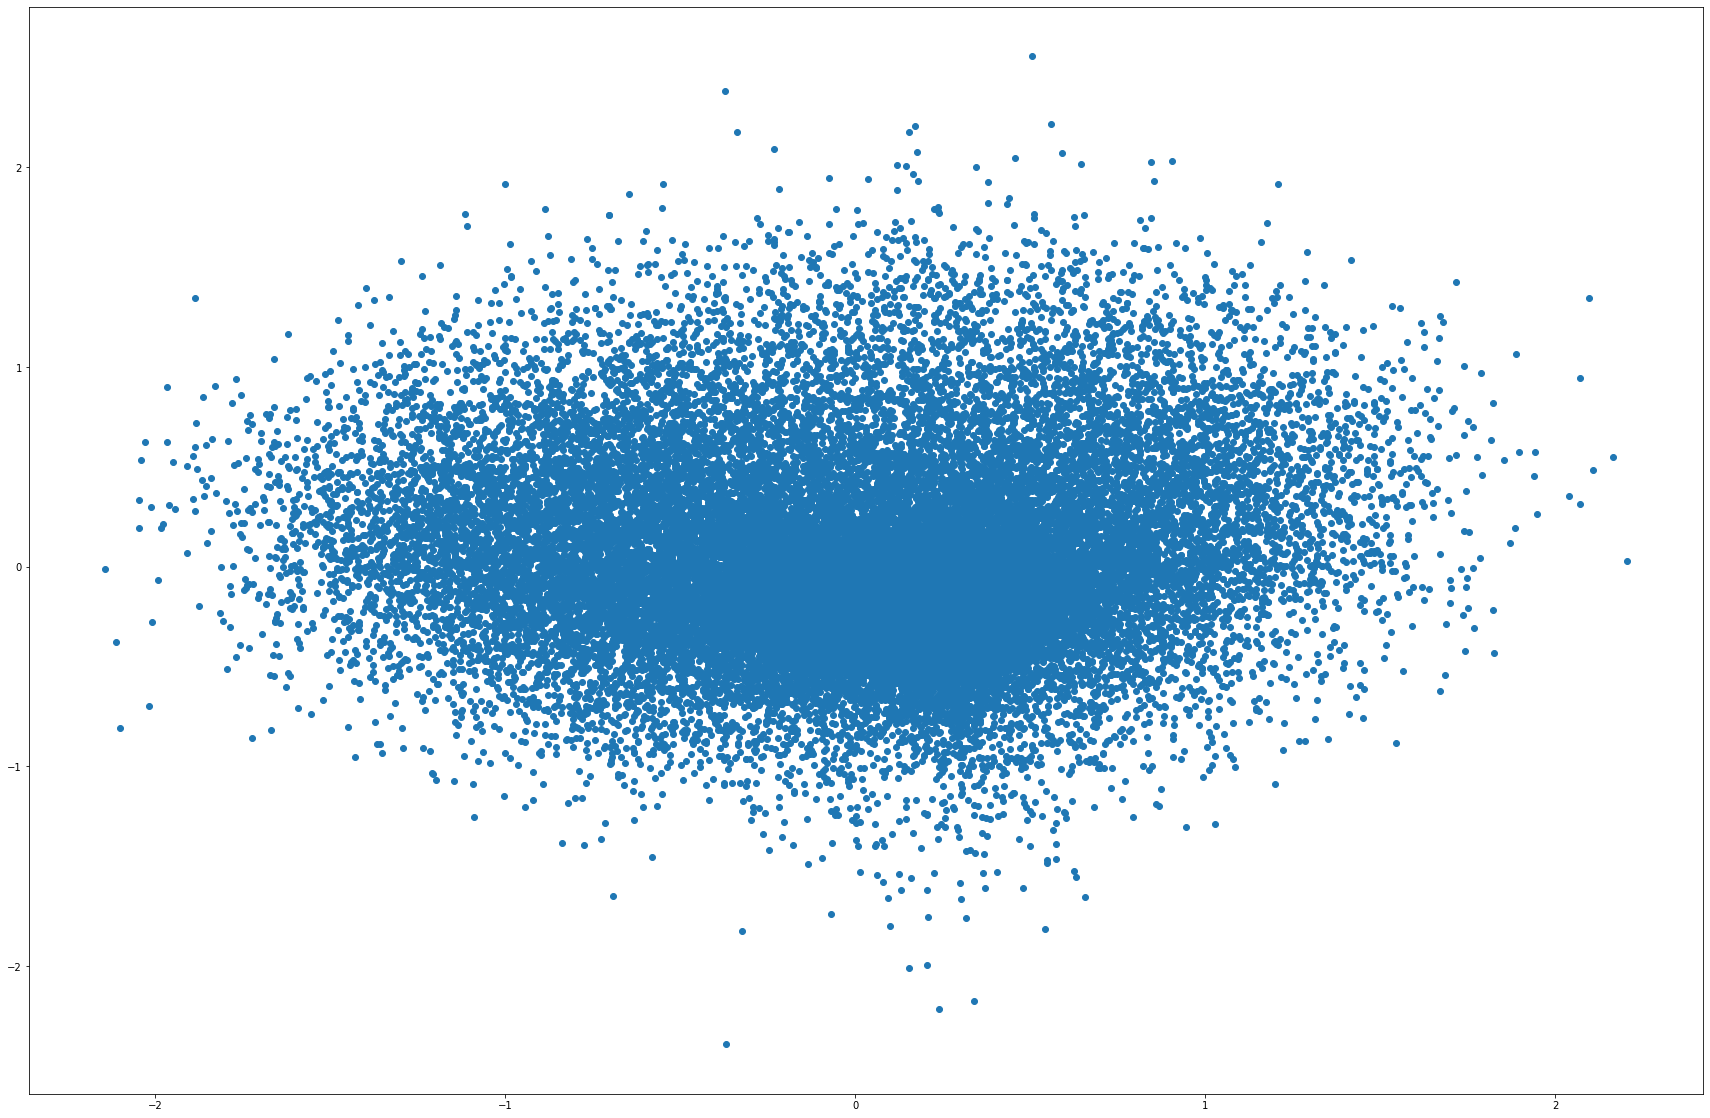

In [49]:
plot_2d_graph(vocabs, xs, ys)

# **작가별 Word2Vec 시각화**

In [50]:
author_0 = train[train['author'] == 0]['text']
author_1 = train[train['author'] == 1]['text']
author_2 = train[train['author'] == 2]['text']
author_3 = train[train['author'] == 3]['text']
author_4 = train[train['author'] == 4]['text']

In [51]:
author_0_token = [word_tokenize(sentence) for sentence in author_0]
author_1_token = [word_tokenize(sentence) for sentence in author_1]
author_2_token = [word_tokenize(sentence) for sentence in author_2]
author_3_token = [word_tokenize(sentence) for sentence in author_3]
author_4_token = [word_tokenize(sentence) for sentence in author_4]

In [52]:
model_0 = Word2Vec(sentences = author_0_token, size = 30, window = 3, min_count = 1, sg = 1, workers = 4, iter = 20)
model_1 = Word2Vec(sentences = author_1_token, size = 30, window = 3, min_count = 1, sg = 1, workers = 4, iter = 20)
model_2 = Word2Vec(sentences = author_2_token, size = 30, window = 3, min_count = 1, sg = 1, workers = 4, iter = 20)
model_3 = Word2Vec(sentences = author_3_token, size = 30, window = 3, min_count = 1, sg = 1, workers = 4, iter = 20)
model_4 = Word2Vec(sentences = author_4_token, size = 30, window = 3, min_count = 1, sg = 1, workers = 4, iter = 20)

In [53]:
vocabs_0 = model_0.wv.vocab.keys()
vocabs_1 = model_1.wv.vocab.keys()
vocabs_2 = model_2.wv.vocab.keys()
vocabs_3 = model_3.wv.vocab.keys()
vocabs_4 = model_4.wv.vocab.keys()

In [54]:
word_vectors_list_0 = [model_0.wv[v] for v in vocabs_0]
word_vectors_list_1 = [model_1.wv[v] for v in vocabs_1]
word_vectors_list_2 = [model_2.wv[v] for v in vocabs_2]
word_vectors_list_3 = [model_3.wv[v] for v in vocabs_3]
word_vectors_list_4 = [model_4.wv[v] for v in vocabs_4]

In [55]:
# 2차원 시각화
pca = PCA(n_components = 2)

In [56]:
xys_0 = pca.fit_transform(word_vectors_list_0)
xys_1 = pca.fit_transform(word_vectors_list_1)
xys_2 = pca.fit_transform(word_vectors_list_2)
xys_3 = pca.fit_transform(word_vectors_list_3)
xys_4 = pca.fit_transform(word_vectors_list_4)

In [57]:
labels = ['author_0', 'author_1', 'author_2', 'author_3', 'author_4']
data = {'author_0' : xys_0,
        'author_1' : xys_1,
        'author_2' : xys_2,
        'author_3' : xys_3,
        'author_4' : xys_4,}
colors = ['b', 'g', 'r', 'y', 'c']
markers = ['o', 'x', '^', 's', '*']
sizes = [30, 30, 30, 30, 30]
widths = [0.5, 0.5, 0.5, 0.5, 0.5]

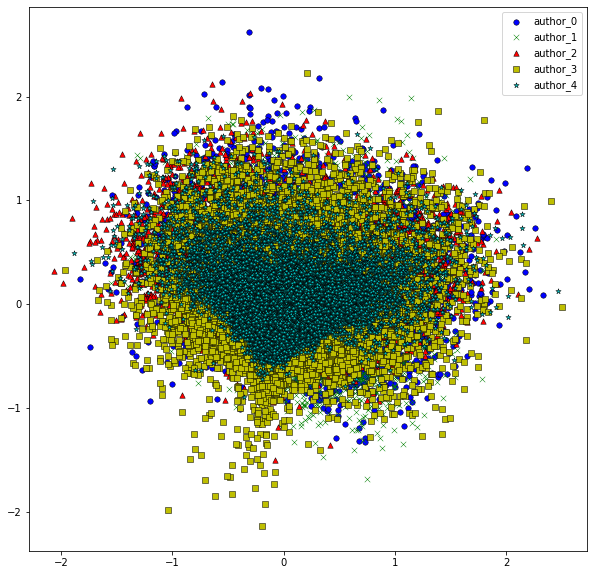

In [58]:
fig = plt.figure(figsize = (10, 10))
for i, label in enumerate(labels):
  X = data[label][:,0]
  Y = data[label][:,1]
  plt.scatter(X, Y, marker=markers[i], color=colors[i], label=label,
             s=sizes[i], edgecolor='k', linewidth=widths[i])
plt.legend(loc='best')

In [63]:
# 3차원 시각화
pca = PCA(n_components = 3)

In [64]:
xys_0 = pca.fit_transform(word_vectors_list_0)
xys_1 = pca.fit_transform(word_vectors_list_1)
xys_2 = pca.fit_transform(word_vectors_list_2)
xys_3 = pca.fit_transform(word_vectors_list_3)
xys_4 = pca.fit_transform(word_vectors_list_4)

In [65]:
labels = ['author_0', 'author_1', 'author_2', 'author_3', 'author_4']
data = {'author_0' : xys_0,
        'author_1' : xys_1,
        'author_2' : xys_2,
        'author_3' : xys_3,
        'author_4' : xys_4,}
colors = ['b', 'g', 'r', 'y', 'c']
markers = ['o', 'x', '^', 's', '*']
sizes = [30, 30, 30, 30, 30]
widths = [0.5, 0.5, 0.5, 0.5, 0.5]

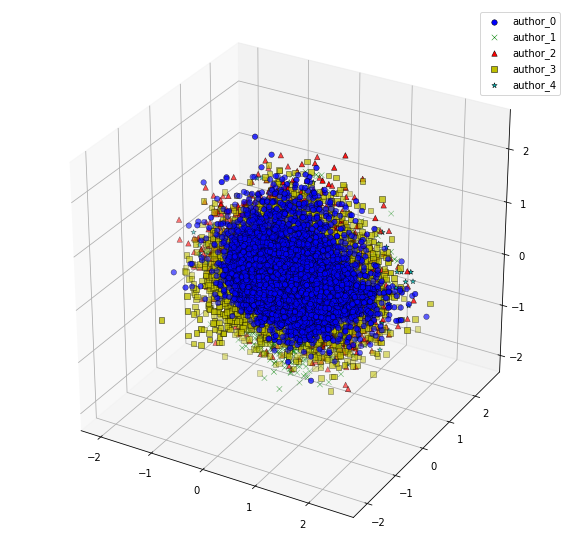

In [66]:
fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection = '3d')
# ax = fig.add_subplot(111, projection='3d')
for i, label in enumerate(labels):
  X = data[label][:,0]
  Y = data[label][:,1]
  Z = data[label][:,2]
  ax.scatter(X, Y, Z, marker=markers[i], color=colors[i], label=label,
             s=sizes[i], edgecolor='k', linewidth=widths[i])
ax.legend(loc='best')

plt.show()